In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('..')
from fastai.vision import *
from audio import *
import matplotlib.pyplot as plt
import math

In [3]:
torch.cuda.is_available()

True

In [4]:
path = Path('data/emotions')
rootdir = path/'ravdess_audio/Audio_Speech_Actors_01-24'

modalities = {
    '01': 'full-AV',
    '02': 'video-only',
    '03': 'audio-only'
}
vocal_channels = {
    '01': 'speech',
    '02': 'song'
}
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
emotional_intensities = {
    '01': 'normal',
    '02': 'strong'
}
statements = {
    '01': 'Kids are talking by the door',
    '02': 'Dogs are sitting by the door'
}
repetitions = {
    '01': '1st repetition',
    '02': '2nd repetition'
}


def get_gender(code):
    tmp = eval(code.lstrip('0'))
    if tmp % 2 == 0:
        return 'female'
    else:
        return 'male'

from collections import defaultdict
genders = defaultdict(lambda: get_gender)

def label_func(fn):
    """
    File naming convention

    Each of the 7356 RAVDESS files has a unique filename. 
    The filename consists of a 7-part numerical identifier
    (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the 
    stimulus characteristics: 

    Filename identifiers 

    Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    Vocal channel (01 = speech, 02 = song).
    Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad,
             05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    Repetition (01 = 1st repetition, 02 = 2nd repetition).
    Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

    Filename example: 02-01-06-01-02-01-12.mp4 

    Video-only (02)
    Speech (01)
    Fearful (06)
    Normal intensity (01)
    Statement "dogs" (02)
    1st Repetition (01)
    12th Actor (12)
    Female, as the actor ID number is even.
    """
    tmp = fn.replace('.wav', '')
    splt = tmp.split('-')
    return {
        'modality': modalities[splt[0]],
        'vocal_channel': vocal_channels[splt[1]],
        'emotion': emotions[splt[2]],
        'emotional_intensity': emotional_intensities[splt[3]],
        'statement': statements[splt[4]],
        'repetition': repetitions[splt[5]],
        'gender': genders[splt[6]](splt[6]),
        'person_id': splt[6]
    }

In [5]:
fp = Path('/course-v3/nbs/dl1/data/emotions/ravdess_audio/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

{'modality': 'audio-only', 'vocal_channel': 'speech', 'emotion': 'neutral', 'emotional_intensity': 'normal', 'statement': 'Kids are talking by the door', 'repetition': '1st repetition', 'gender': 'male', 'person_id': '01'}


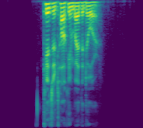

In [6]:
import librosa.display
y, sr = librosa.load(fp)
display(Audio(y, rate=sr))
# https://nbviewer.jupyter.org/github/mogwai/fastai_audio/blob/master/tutorials/01_Intro_to_Audio.ipynb#HyperParameter-Cheat-Sheet
config = {
    'sr': 16000,
    'hop_length': 512,
    'power': 1.0,
    'n_mels': 128,
    'fmin': 0.0,
    'fmax': 8000,
    'ref': 1.0, 
    'amin': 1e-05,
    'top_db': 80.0,
}
config['n_fft'] = 20 * config['n_mels']

dirname = \
    '_'.join([
    str(config['sr']),
    str(config['n_fft']),
    str(config['hop_length']),
    str(config['power']),
    str(config['n_mels']),
    str(config['fmin']),
    str(config['fmax']),
    str(config['ref']),
    str(config['amin']),
    str(config['top_db']),
    str(config['fmax'])]
)
sg = librosa.feature.melspectrogram(
    y, sr=config['sr'],  n_fft=config['n_fft'], 
    hop_length=config['hop_length'],
    power=config['power'], n_mels=config['n_mels'],
    fmin=config['fmin'], fmax=config['fmax']
)
db_spec = librosa.amplitude_to_db(
    sg, ref=config['ref'], amin=config['amin'], top_db=config['top_db'])
print(label_func(fp.name))
Image(torch.from_numpy(db_spec).unsqueeze(0))

In [7]:
data_folder = rootdir

In [8]:
def emotion_label(fp):
    return label_func(fp.name)['emotion']

In [9]:
%%time
config = AudioConfig(
    remove_silence="trim",
    use_spectro=True,
    # downmix=True
)
config.resample_to = 8000
# config.sg_cfg = SpectrogramConfig(hop_length=256, n_mels=192)
audios_sg = AudioList.from_folder(
    data_folder, config=config) \
    .split_by_rand_pct(.2, seed=4) \
    .label_from_func(func=emotion_label)

ImportError: /opt/conda/lib/python3.6/site-packages/_torch_sox.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN3c105ErrorC1ENS_14SourceLocationERKSs

In [31]:
data = audios_sg.databunch(bs=64)

You can deactivate this warning by passing `no_check=True`.


/fastai/fastai/basic_data.py:272: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([1, 128, 63]), torch.Size([1, 128, 76]), torch.Size([1, 128, 63]), torch.Size([1, 128, 88]), torch.Size([1, 128, 69]), torch.Size([1, 128, 82]), torch.Size([1, 128, 88]), torch.Size([1, 128, 57]), torch.Size([1, 128, 69]), torch.Size([1, 128, 63]), torch.Size([1, 128, 76]), torch.Size([1, 128, 76]), torch.Size([1, 128, 82]), torch.Size([1, 128, 76]), torch.Size([1, 128, 63]), torch.Size([1, 128, 69]), torch.Size([1, 128, 76]), torch.Size([1, 128, 69]), torch.Size([1, 128, 82]), torch.Size([1, 128, 63]), torch.Size([1, 128, 82]), torch.Size([1, 128, 69]), torch.Size([1, 128, 57]), torch.Size([1, 128, 69]), torch.Size([1, 128, 69]), torch.Size([1, 128, 69]), torch.Size([1, 128, 63]), torch.Size([1, 128, 89]), torch.Size([1, 128, 63]), torch.Size([1, 128, 113]), torch.Size([1, 128, 57]), torch.Size([1, 128, 63]), torch.Size([1,

In [25]:
print('classes:', len(data.classes))
print('samples in training:', len(data.train_ds))
print('samples in validation:', len(data.valid_ds))

classes: 8
samples in training: 1152
samples in validation: 288


In [20]:
learn = audio_learner(data)
learn.fit_one_cycle(5)
# learn.unfreeze()
# learn.fit_one_cycle(10, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/fastai/fastai/torch_core.py", line 127, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [1, 192, 63] at entry 0 and [1, 192, 76] at entry 2


In [ ]:
torch.